# Sentiment Analysis on Movie Reviews
<b>Members:</b>
<ol>
    <li> Kishan Kumar (16115061) </li>
    <li> Muskan Mittal (16115074) </li>
    <li> Akshit Gupta</li>
    <li> Mehek Mittal </li>
</ol>

# About
<br>
<p>The objective of this project is to try out different deep learning algorithm and compare them based on how well they perform.</p>
Following are the various approaches used:
<ul>
    <li> Long short term memory (LSTM) cells.</li>
    <li> Convolutional Neural Networks </li>
    <li> LSTM followed by CNN </li>
    <li> CNN followed by LSTM </li>
</ul>

In [2]:
# importing some basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## a brief about our Data...
what kind of data are we using?<br>
We are using the data from kaggle hosted competition.

In [3]:
train = pd.read_csv('train.tsv', sep='\t')
test = pd.read_csv('test.tsv', sep='\t')

In [4]:
train[0:10]

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


The dataset consist of <b>4 columns</b>, mainly we are focused toward the <b>Phrase</b> and the associated <b>Sentiment</b>. <br>
Notice that the subsequent phrases are just a part of the main sentence and to tell that a phrase is a part of the main sentence we have sentenceID.

In [5]:
# Let's convert the Sentiment column to string, so that we can use a library to convert it into one hot encoding easily
train['Sentiment'] = train['Sentiment'].apply(str)

In [6]:
# let's see the polarity of our dataset
train.Sentiment.value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

Mostly we have the phrases having sentiment as <b>2</b>, this is because the dataset consists of mostly one or two word phrases. for example, <b>"of"</b>, <b>"the"</b>, <b>"series"</b> these words are one way or other neutral and our data is plagued by these phrases only. <br> But we can't just remove one word phrases because it might be the case that some one word may consist of <b>"good"</b>, <b>"best"</b>, <b>"excellent"</b>, <b>"outstanding"</b>, you got the point.
<br>
From the above inference we got to know that we have 5 unique sentiments, ranging from 0 to 4 with 0 signifying very poor and 4 signifying outstanding.<br><br>
The phrases as you might guess consists of words that are not relevant, what i mean by it is that they don't contribute in determining the context as well as the polarity of the sentence. These words are redundant and doesn't affect the performance of our deep learning model if removed.
<br>
The <b>Natural Language Toolkit (NLTK)</b> provides us some libraries to help us with that sort of problems.

In [7]:
# importing libraries related to the text processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

<b>What does these libraries do?</b><br>
<p>well, tokenize is to convert a word to numeric value, basically it is a mapping of words, because deep learning models are trained on numbers and not text.</p>
<p> WordNetLemmatizer is used to stem the words, for e.g. running, run, ran they all have the same stem i.e. run, but the deep learning model will consider as if it is different, so we stem them, such that there meaning is still preserved.</p>

In [103]:
# importing keras libraries
from keras.utils import to_categorical
import random
from tensorflow import set_random_seed
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Dropout, Embedding, LSTM, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential

In [9]:
# setting the seed so that the weights that will be initialised in mine or in your will be same that is our initial state will be same
set_random_seed(5)
random.seed(5)

In [10]:
train.shape

(156060, 4)

In [11]:
test.shape

(66292, 3)

## Data Preprocessing Phase
In this phase we'll be cleaning our data, what i mean by cleaning is to perform the following operations
<ul>
    <li> Remove non-alphabetical characters </li>
    <li> Tokenize the sentences </li>
    <li> Lemmatize each word to its basic form </li>
</ul>

In [12]:
# initialize the WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [13]:
def preprocess(df):
    """
    returns a list of clean reviews after applying all the three operations mentioned above
    Input:
        df : a dataframe consisting of our required data
    """
    reviews = []
    for sentence in tqdm(df['Phrase']):
        # basically we are working on each phrase from a list of phrases, tqdm to just show the progressbar in the notebook
        clean_phrase = re.sub("[^a-zA-Z]", " ", sentence) # replace all the non-alphabetical character with a space
        words = word_tokenize(clean_phrase.lower()) # tokenize the sentence (break the sentences into words that's it)
        lemma_words = [lemmatizer.lemmatize(word) for word in words]
        reviews.append(lemma_words)
    return(reviews)

In [14]:
# let's call our preprocess function over train and test dataset
train_phrases = preprocess(train)
test_phrases = preprocess(test)

100%|██████████| 66292/66292 [00:07<00:00, 8518.63it/s]


In [16]:
# we need to convert the categorical variable which was the sentiment to one-hot encoding
sentiment = train.Sentiment.values
y = to_categorical(sentiment)
num_classes = y.shape[1]

In [17]:
print(num_classes)

5


## Split the training and validation sets

In [18]:
X_train, X_val, y_train, y_val = train_test_split(train_phrases, y, test_size=0.2, stratify=y)

We are using <b>stratify = y</b>, it aims at splitting the dataset in such a way that the proportion of the classes will be same in the split.<br>
In a classification setting, it is often chosen to ensure that the train and test sets have approximately the same percentage of samples of each target class as the complete set

In [42]:
# an overview of what we have present in the training and validation set
print("Data present in the training set...")
for i, phrase in enumerate(X_train[0:5]):
    print("phrase {0}: {1}".format(i, phrase))

print("\n\nData present in the validation set...")
for i, phrase in enumerate(X_val[0:5]):
    print("phrase {0}: {1}".format(i, phrase))

Data present in the training set...
phrase 0: ['a', 'jaunt', 'down', 'memory', 'lane', 'for', 'teen', 'and']
phrase 1: ['suck', 'but', 'ha', 'a', 'funny', 'moment', 'or', 'two']
phrase 2: ['of', 'the', 'post', 'war', 'art', 'world']
phrase 3: ['this', 'is', 'a', 'lax', 'and', 'limp', 'a', 'comedy', 'a', 'i', 've', 'seen', 'in', 'a', 'while', 'a', 'meander', 'through', 'worn', 'out', 'material']
phrase 4: ['started', 'hanging', 'out', 'at', 'the', 'barbershop']


Data present in the validation set...
phrase 0: ['putrid']
phrase 1: ['you', 'saw', 'it', 'on', 'tv']
phrase 2: ['the', 'movie', 'will', 'live', 'up', 'to', 'the', 'apparent', 'skill', 'of', 'it', 'maker', 'and', 'the', 'talent', 'of', 'it', 'actor']
phrase 3: ['appropriated']
phrase 4: ['historical', 'subject']


In [49]:
# let's find out the total unique words that we have in our dataset and also gettting the length of the reviews
unique_words  = set() # why set? because set has a property that every element stored will be present only once
max_len = 0; # to store the maximum length of the review found so far

for sentence in tqdm(train_phrases):
    unique_words.update(sentence)
    if(max_len < len(sentence)):
        max_len = len(sentence)

for sentence in tqdm(test_phrases):
    unique_words.update(sentence)
    
print("total unique words found in our complete dataset : {0}".format(len(list(unique_words))))
print("max length of a phrase found in our testing phase is : {0}" .format(max_len))

100%|██████████| 66292/66292 [00:00<00:00, 1332340.49it/s]

total unique words found in our complete dataset : 15884
max length of a phrase found in our testing phase is : 48


Why we are including the <b>test_phrases</b> in order to find the unique_words, because we want our model to know beforehand how many unique words is it expecting. <br>for example let's say that there is a word present in our test phase which was not present in the training phase due to which we do not have its mapping, this will be a problem and our model will suffer.

## Tokenization
In this section we'll be going to get the mapping of our words to numbers, and we will also convert them into sequences which means we will pad them such that all the phrases have same lengths.

In [50]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(X_train))

In [52]:
def text_to_sequence(texts, tokenizer):
    """
    it basically converts a list of texts to sequences
    input: 
    texts - a list of text
    tokenizer - an instance of Tokenizer that has been fitted on the phrases
    """
    return tokenizer.texts_to_sequences(texts)

In [53]:
def pad_sequences(sequences, max_len):
    """
    it pads the sequences so that they all have same size of max_len by adding zeros
    input:
    sequences - a list of sequences
    max_len - the size that we want in the end
    """
    return sequence.pad_sequences(sequences, max_len)

In [54]:
X_train = text_to_sequence(X_train, tokenizer)
X_val = text_to_sequence(X_val, tokenizer)
X_test = text_to_sequence(test_phrases, tokenizer)

In [57]:
# let's have a look at it
print("Tokenized phrases present in the training set...")
for i, phrase in enumerate(X_train[0:5]):
    print("phrase {0}: {1}".format(i, phrase))

print("\n\Tokenized phrases present in the validation set...")
for i, phrase in enumerate(X_val[0:5]):
    print("phrase {0}: {1}".format(i, phrase))

Tokenized phrases present in the training set...
phrase 0: [2, 5401, 163, 587, 1557, 14, 352, 4]
phrase 1: [1809, 17, 37, 2, 70, 136, 30, 97]
phrase 2: [3, 1, 899, 181, 236, 120]
phrase 3: [16, 9, 2, 10851, 4, 3411, 2, 54, 2, 62, 220, 201, 8, 2, 168, 2, 5402, 107, 2001, 41, 207]
phrase 4: [2089, 5967, 41, 29, 1, 2053]

\Tokenized phrases present in the validation set...
phrase 0: [5835]
phrase 1: [19, 747, 6, 20, 314]
phrase 2: [1, 12, 71, 401, 44, 5, 1, 1589, 792, 3, 6, 1357, 4, 1, 418, 3, 6, 133]
phrase 3: [11548]
phrase 4: [550, 210]


As we can infer that all the phrases have different lengths, and for the LSTMs we want the sequences to be having the same size so we'll pad these sequences with 0

In [58]:
# let's add padding
X_train = pad_sequences(X_train, max_len)
X_val = pad_sequences(X_val, max_len)
X_test = pad_sequences(X_test, max_len)

In [61]:
# let's have a look at it
print("Tokenized phrases along with padding present in the training set...")
for i, phrase in enumerate(X_train[0:2]):
    print("phrase {0}: {1}".format(i, phrase))

print("\nTokenized phrases along with padding present in the validation set...")
for i, phrase in enumerate(X_val[0:2]):
    print("phrase {0}: {1}".format(i, phrase))

Tokenized phrases along with padding present in the training set...
phrase 0: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    2 5401
  163  587 1557   14  352    4]
phrase 1: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0 1809   17
   37    2   70  136   30   97]

Tokenized phrases along with padding present in the validation set...
phrase 0: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0 5835]
phrase 1: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0 

As we can see most of the segment present in the phrase is padded with zero

In [63]:
print("Shape of the training set: {0}".format(np.shape(X_train)))
print("Shape of the validation set: {0}".format(np.shape(X_val)))
print("Shape of the testing set: {0}".format(np.shape(X_test)))

Shape of the training set: (124848, 48)
Shape of the validation set: (31212, 48)
Shape of the testing set: (66292, 48)


### Callbacks
We'll be using two callbacks in this project.
<ol>
    <li> <b>Early Stopping</b> : this helps our model to stop early if our model is not learning anything at all for a consectutive no of epochs, that is also tuneable</li>
    <li> <b>ModelCheckpoint</b> : this helps us to save the model after each epoch based on some criterion for example save only when our model has performed better on the validation loss</li>
</ol>

In [66]:
our_callbacks = [EarlyStopping(monitor="val_acc", patience=5, min_delta=0.001, mode="max"),
                ModelCheckpoint(filepath="dbms_model.h5", save_best_only=True, save_weights_only=False)]

## Model - 1
We'll be using several different model and test them on our validation set to know which performed better. <br>
In our first model we'll be using only LSTMs

In [75]:
model = Sequential(name="Model #1")
model.add(Embedding(len(list(unique_words)), 256, input_length=max_len, name="Embedding"))
model.add(LSTM(128, dropout=0.5, recurrent_dropout=0.5, return_sequences=True, name="LSTM1"))
model.add(LSTM(64, dropout=0.5, recurrent_dropout=0.5, return_sequences=False, name="LSTM2"))
model.add(Dense(100, activation="relu", name="Dense1"))
model.add(Dropout(0.5, name="Dropout1"))
model.add(Dense(num_classes, activation="softmax", name="Output"))
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.005), metrics=['accuracy'])
model.summary()

Model: "Model #1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, 48, 256)           4066304   
_________________________________________________________________
LSTM1 (LSTM)                 (None, 48, 128)           197120    
_________________________________________________________________
LSTM2 (LSTM)                 (None, 64)                49408     
_________________________________________________________________
Dense1 (Dense)               (None, 100)               6500      
_________________________________________________________________
Dropout1 (Dropout)           (None, 100)               0         
_________________________________________________________________
Output (Dense)               (None, 5)                 505       
Total params: 4,319,837
Trainable params: 4,319,837
Non-trainable params: 0
________________________________________________

In [77]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3, batch_size=256, verbose=1, callbacks=our_callbacks)

Train on 124848 samples, validate on 31212 samples
Epoch 1/3
124848/124848 [==============================] - 260s 2ms/step - loss: 0.9347 - acc: 0.6210 - val_loss: 0.8314 - val_acc: 0.6563
Epoch 2/3
124848/124848 [==============================] - 282s 2ms/step - loss: 0.7897 - acc: 0.6730 - val_loss: 0.8014 - val_acc: 0.6719
Epoch 3/3
124848/124848 [==============================] - 282s 2ms/step - loss: 0.7303 - acc: 0.6961 - val_loss: 0.8122 - val_acc: 0.6696


## Results

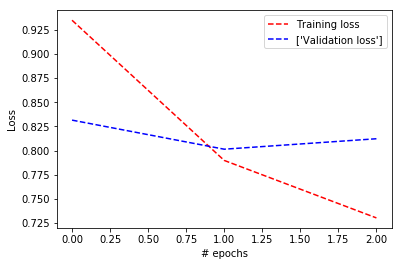

In [78]:
plt.plot(history.history['loss'], 'r--')
plt.plot(history.history['val_loss'], 'b--')
plt.legend(['Training loss', 'Validation loss'])
plt.xlabel("# epochs")
plt.ylabel("Loss")
plt.show()

## Model - 2
We'll be using CNN + LSTM, let's see will the accuracy improve?

In [83]:
# importing libraries associated with convolutions
from keras.layers import Conv1D, MaxPooling1D

In [89]:
# defining second callbacks
our_callbacks2 = [EarlyStopping(monitor="val_acc", patience=5, min_delta=0.001, mode="max"),
                ModelCheckpoint(filepath="dbms_model_cnn_lstm.h5", save_best_only=True, save_weights_only=False)]

In [90]:
model2 = Sequential(name="Model #2")
model2.add(Embedding(len(list(unique_words)), 256, input_length=max_len, name="Embedding"))
model2.add(Conv1D(32, 2, name="Conv1", padding="same"))
model2.add(MaxPooling1D(name="MaxPool1"))
model2.add(Dropout(0.5, name="Dropout1"))
model2.add(Conv1D(64, 2, name="Conv2", padding="same"))
model2.add(MaxPooling1D(name="MaxPool2"))
model2.add(Dropout(0.5, name="Dropout2"))
model2.add(LSTM(128, dropout=0.5, recurrent_dropout=0.5, name="LSTM1"))
model2.add(LSTM(128, dropout=0.5, recurrent_dropout=0.5, name="LSTM2"))
model2.add(Dense(5, activation="softmax", name="output"))
model2.compile(optimizer=Adam(lr=0.005), loss="categorical_crossentropy", metrics=['accuracy'])
model2.summary()

Model: "Model #2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, 48, 256)           4066304   
_________________________________________________________________
Conv1 (Conv1D)               (None, 48, 32)            16416     
_________________________________________________________________
MaxPool1 (MaxPooling1D)      (None, 24, 32)            0         
_________________________________________________________________
Dropout1 (Dropout)           (None, 24, 32)            0         
_________________________________________________________________
Conv2 (Conv1D)               (None, 24, 64)            4160      
_________________________________________________________________
MaxPool2 (MaxPooling1D)      (None, 12, 64)            0         
_________________________________________________________________
Dropout2 (Dropout)           (None, 12, 64)            0  

In [98]:
history2 = model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=256, verbose=1, callbacks=our_callbacks2)


Train on 124848 samples, validate on 31212 samples
Epoch 1/20
124848/124848 [==============================] - 82s 658us/step - loss: 0.9305 - acc: 0.6192 - val_loss: 0.8868 - val_acc: 0.6372
Epoch 2/20
124848/124848 [==============================] - 72s 579us/step - loss: 0.8797 - acc: 0.6356 - val_loss: 0.8931 - val_acc: 0.6346
Epoch 3/20
124848/124848 [==============================] - 69s 551us/step - loss: 0.8790 - acc: 0.6335 - val_loss: 0.9010 - val_acc: 0.6302
Epoch 4/20
124848/124848 [==============================] - 69s 555us/step - loss: 0.8882 - acc: 0.6318 - val_loss: 0.9319 - val_acc: 0.6202
Epoch 5/20
124848/124848 [==============================] - 70s 561us/step - loss: 0.9003 - acc: 0.6257 - val_loss: 0.9506 - val_acc: 0.6166
Epoch 6/20
124848/124848 [==============================] - 70s 564us/step - loss: 0.9099 - acc: 0.6222 - val_loss: 0.9560 - val_acc: 0.6120


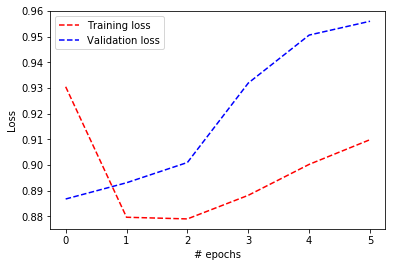

In [99]:
plt.plot(history2.history['loss'], 'r--')
plt.plot(history2.history['val_loss'], 'b--')
plt.legend(['Training loss', 'Validation loss'])
plt.xlabel("# epochs")
plt.ylabel("Loss")
plt.show()

## Model - 3
In this we'll be using LSTM + CNN

In [100]:
# defining third callbacks
our_callbacks3 = [EarlyStopping(monitor="val_acc", patience=5, min_delta=0.001, mode="max"),
                ModelCheckpoint(filepath="dbms_model_lstm_cnn.h5", save_best_only=True, save_weights_only=False)]

In [104]:
model3 = Sequential(name="Model #3")
model3.add(Embedding(len(list(unique_words)), 256, input_length=max_len, name="Embedding"))
model3.add(LSTM(64, dropout=0.5, recurrent_dropout=0.5, name="LSTM1", return_sequences=True))
model3.add(LSTM(128, dropout=0.5, recurrent_dropout=0.5, name="LSTM2", return_sequences=True))
model3.add(Conv1D(32, 2, name="Conv1", padding="same"))
model3.add(MaxPooling1D(name="MaxPool1"))
model3.add(Dropout(0.5, name="Dropout1"))
model3.add(Conv1D(64, 2, name="Conv2", padding="same"))
model3.add(MaxPooling1D(name="MaxPool2"))
model3.add(Dropout(0.5, name="Dropout2"))
model3.add(Flatten())
model3.add(Dense(5, activation="softmax", name="output"))
model3.compile(optimizer=Adam(lr=0.005), loss="categorical_crossentropy", metrics=['accuracy'])
model3.summary()

Model: "Model #3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, 48, 256)           4066304   
_________________________________________________________________
LSTM1 (LSTM)                 (None, 48, 64)            82176     
_________________________________________________________________
LSTM2 (LSTM)                 (None, 48, 128)           98816     
_________________________________________________________________
Conv1 (Conv1D)               (None, 48, 32)            8224      
_________________________________________________________________
MaxPool1 (MaxPooling1D)      (None, 24, 32)            0         
_________________________________________________________________
Dropout1 (Dropout)           (None, 24, 32)            0         
_________________________________________________________________
Conv2 (Conv1D)               (None, 24, 64)            416

In [105]:
history3 = model3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=256, verbose=1, callbacks=our_callbacks3)


Train on 124848 samples, validate on 31212 samples
Epoch 1/20
124848/124848 [==============================] - 242s 2ms/step - loss: 1.0676 - acc: 0.5757 - val_loss: 0.8771 - val_acc: 0.6371
Epoch 2/20
124848/124848 [==============================] - 231s 2ms/step - loss: 0.8636 - acc: 0.6482 - val_loss: 0.8441 - val_acc: 0.6541
Epoch 3/20
124848/124848 [==============================] - 632s 5ms/step - loss: 0.7991 - acc: 0.6733 - val_loss: 0.8264 - val_acc: 0.6592
Epoch 4/20
124848/124848 [==============================] - 302s 2ms/step - loss: 0.7614 - acc: 0.6864 - val_loss: 0.8354 - val_acc: 0.6691
Epoch 5/20
124848/124848 [==============================] - 258s 2ms/step - loss: 0.7343 - acc: 0.6973 - val_loss: 0.8366 - val_acc: 0.6686
Epoch 6/20
124848/124848 [==============================] - 276s 2ms/step - loss: 0.7177 - acc: 0.7032 - val_loss: 0.8298 - val_acc: 0.6707
Epoch 7/20
124848/124848 [==============================] - 236s 2ms/step - loss: 0.7040 - acc: 0.7067 - val_

KeyboardInterrupt: 

In [107]:
plt.plot(history3.history['loss'], 'r--')
plt.plot(history3.history['val_loss'], 'b--')
plt.legend(['Training loss', 'Validation loss'])
plt.xlabel("# epochs")
plt.ylabel("Loss")
plt.show()

# Prediction

In [110]:
from keras.models import load_model
model = load_model('dbms_model.h5')
model2 = load_model('dbms_model_cnn_lstm.h5')
model3 = load_model('dbms_model_lstm_cnn.h5')

In [111]:
# we'll be making prediction based on all the three models
y_pred_1 = model.predict_classes(X_test)

sub_file = pd.read_csv('sampleSubmission.csv', sep=',')
sub_file.Sentiment = y_pred_1
sub_file.to_csv('SubmissionModel1.csv', index=False)

In [112]:
y_pred_2 = model2.predict_classes(X_test)
sub_file = pd.read_csv('sampleSubmission.csv', sep=',')
sub_file.Sentiment = y_pred_2
sub_file.to_csv('SubmissionModel2.csv', index=False)

In [113]:
y_pred_3 = model3.predict_classes(X_test)
sub_file = pd.read_csv('sampleSubmission.csv', sep=',')
sub_file.Sentiment = y_pred_3
sub_file.to_csv('SubmissionModel3.csv', index=False)

# Kaggle Score

for model1
<img src='kaggle_1.PNG'><br>
for model3
<img src='kaggle_2.PNG'>